<a href="https://colab.research.google.com/github/JoseNunes24/ExpeditionAnalysis/blob/master/Expedition_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload Necessary Files

##Import Main files

In [0]:
url_1 = 'https://raw.githubusercontent.com/JoseNunes24/ExpeditionAnalysis/master/2017.csv'

url_2 = 'https://raw.githubusercontent.com/JoseNunes24/ExpeditionAnalysis/master/2018.csv'


## Import Auxiliar tables

In [0]:
url_country = 'https://raw.githubusercontent.com/JoseNunes24/ExpeditionAnalysis/master/CCMasked.csv'

url_mm = 'https://raw.githubusercontent.com/JoseNunes24/ExpeditionAnalysis/master/MMMasked.csv'



## Import libraries and data

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
from datetime import datetime, timedelta
from itertools import islice

df2 = pd.read_csv(url_1, encoding='latin-1', sep=';') 
 # Dataset is now stored in a Pandas Dataframe

df2 = df2.append(pd.read_csv(url_2, encoding='latin-1', sep=';'), ignore_index=True)

dfCountry = pd.read_csv(url_country, encoding='latin-1', sep=';') 

dfMaterial = pd.read_csv(url_mm, encoding='latin-1', sep=';')

dfLbrand = pd.DataFrame({'LBrand': [5, 10, 20, 25, 40], 
                           'Marketing Label': ['Elven', 'SpecOps', 
                                               'FF', 'WOK', 'ZZTOP']})

# Manipulating Data

## Cleaning the data

### Columns to appropriate type

In [0]:
df2['Qtty'] = df2['Qtty'].str.replace(' ', '')
df2['Qtty'] = df2['Qtty'].astype(int)

# Sometimes the date may come in 12 hour instead of 24 hour, this can be 
#  improved further (nothing other than an hour value should be in the data, 
#  but a way to prevent that could be written here)
def transform_time (times):
  try:
    return (pd.to_datetime(times, format = ('%H:%M:%S')).dt.time)
  except:
    return (pd.to_datetime(times).strftime('%H:%M:%S'))
   
df2['Time'] = df2.apply(lambda x: 
                                transform_time(x['Time']), axis=1)

# The previous function may not return the same type of object, so this makes 
#  sure it is the right type of time value 
df2['Time'] = pd.to_datetime(
    df2['Time'], format = ('%H:%M:%S')).dt.time

df2['Planned Date'] = (
    pd.to_datetime(df2['Planned Date'], dayfirst=True))

df2['Product'] =  df2['Product'].astype(str)

dfMaterial['Product'] = dfMaterial['Product'].astype(str)

dfLbrand['LBrand'] = dfLbrand['LBrand'].astype(str)


### Real Shipment Date

In [0]:
'''Transform and see if the date is correct

Shipments from before 8AM will be considered from the past day 
  (a new day is considered to be from 8AM, beginning the first shift at that time)

It gets the time, checks if its before 8AM and takes a day from 
  the Planned Date
  
'''

first_shift_time = pd.to_datetime('08:00:00', format = '%H:%M:%S').time()

df2.loc[df2['Time'] < first_shift_time, ['Planned Date']] = (
  df2['Planned Date'] - timedelta(days=1))

### Checking the type of shipment

In [0]:
'''Verifying type of Expedition

  The type of Expedition can be
    
    SP -> Last 4 digits can be "0000" or end with a number in the last digit,
          Ex: "xxxxxx0008"
    EX -> Excluding the last digit, the other 3 penultimate digits have to be
          something other than "0000"
          Ex: "xxxxxx039x"

'''

def type_of_shipment (articleNumber) :
  
  if articleNumber[-4:-1] == '000'  :
    return 'SP'
  else:
    return 'EX'

df2['Type of shipment'] = df2.apply(lambda x: type_of_shipment(x['Product']),
                                    axis=1)

### Merging tables

In [0]:
'''Merging The tables for necessary data
  
  Some information about the products shipped are in different tables,
  specifically:

  - The info about the Marketing Label is from the LBrand table
  - The info about the Country Label is from the CCMasked table
  - Some clients have exceptions, which will be dealt with

'''
# Get the LBrand code of the product
df2 = pd.merge(df2,dfMaterial[['Product','LBrand']], on='Product',
               how='left')

df2['LBrand'] = df2['LBrand'].astype(str)

# Get the Label from the LBrand code
df2 = pd.merge(df2,dfLbrand, on='LBrand',how='left')

# Get the Country Label
df2 = pd.merge(df2,dfCountry[['Country','Label']], on='Country',
               how='left')

### Exceptions to Labels

In [0]:
'''Exceptions to Labels
   
   Some clients, countries and markets have certain types of exceptions
   to labels

'''

# Marketing Label exceptions

clients_ID_Exceptions = set(['3048620', '3128023', '2875903', '2882122'])
country_Exception = 'CI'
markets_Exceptions = set(['Tolkien', 'H.O.B.B.'])

def type_of_label (businessID, MarketingLabel, 
                   shipment_type, country, market): 

  if (businessID in (clients_ID_Exceptions) or shipment_type == 'EX' or 
      country == country_Exception or market in markets_Exceptions): 
    return 'Nada'
  else:
    return MarketingLabel
    
df2['Country'] = df2['Country'].astype(str)
df2['Client ID'] = df2['Client ID'].astype(str)
df2['Label'] = df2['Label'].astype(str)

df2['Marketing Label'] = df2.apply(lambda x: 
                                   type_of_label(
                                       x['Client ID'],
                                       x['Marketing Label'], 
                                       x['Type of shipment'], 
                                       x['Country'], 
                                       x['Label']),
                                   axis=1)

In [0]:
# Country Label exceptions

clients_ID_Exceptions_Country = set(['3048620', '3128023', '2882122',
                                     '3149700', '2880583'])

def country_type_of_label (businessID, shipment_type, market): 

  if (businessID in (clients_ID_Exceptions) or shipment_type == 'EX'):   
    return 'Nada'
  else:
    return market

df2['Label'] = df2.apply(lambda x: 
                                   country_type_of_label (
                                       x['Client ID'],
                                       x['Type of shipment'], 
                                       x['Label']),
                                   axis=1)

### Append the monthly Data to existing Database

In [0]:
#df1.append(d2, ignore_index=True)

## Extracting Valuable Data

In [0]:
#df2.set_index(df2['Planned Loading Date'], inplace=True)

total_number_of_shipments = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month')])['Unit'].nunique()

total_number_of_products = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month')])['Unit'].count()

total_number_of_products_type = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month'), 
     df2['Type of shipment']])['Unit'].count()

total_number_of_shipments_type = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month'),
     df2['Type of shipment']])['Unit'].nunique()

total_labels_Marketing = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month'), 
     df2['Marketing Label']])['Unit'].sum()

total_labels_Country = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month'),
     df2['Label']])['Qtty'].sum()

total_number_of_shipments_city = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month'),
     df2['City']])['Unit'].nunique()

total_number_of_products_city = df2.groupby(
    [df2['Planned Date'].dt.year.rename('Year'), 
     df2['Planned Date'].dt.month.rename('Month'),
     df2['City']])['Unit'].count()


### SP expeditions 

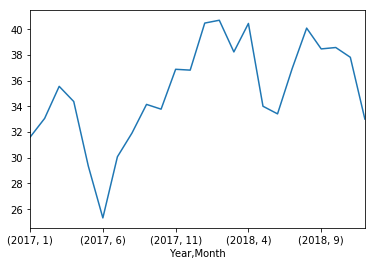

In [15]:
# Table with only SP type shipments
df_SP = df2[df2['Type of shipment'] == 'SP']

# Group the shipments by date
nr_shipments_SP = df_SP.groupby(
    [df_SP['Planned Date'].dt.year.rename('Year'), 
     df_SP['Planned Date'].dt.month.rename('Month')])['Unit'].nunique()

nr_products_SP = df_SP.groupby(
    [df_SP['Planned Date'].dt.year.rename('Year'), 
     df_SP['Planned Date'].dt.month.rename('Month')])['Unit'].count()

# Average of number of different products by shipment and type
complexity = ( nr_products_SP / nr_shipments_SP)

complexity.plot ()

# Top 10 Complexity by city
city_complexity = (
    total_number_of_products_city / total_number_of_shipments_city
    )

# MS vs OE Share
share = (total_number_of_shipments_type / total_number_of_shipments) * 100

In [0]:
'''import matplotlib.pyplot as plt

# gca stands for 'get current axis'

city_complexity.plot(kind='bar', x = '2018')
plt.xlabel'''

In [0]:
'''df2.to_csv('data.csv')
files.download("data.csv")'''
